cf partie 1 : Cutting_Edge.ipynb

# VI/ Sequence Tagging avec bi LSTM-CRF

Importation des librairies

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from keras.preprocessing import sequence
from keras.models import Model
from keras.layers.wrappers import Bidirectional
from keras.layers import Input, LSTM, Dropout, Embedding,Dense
from keras_contrib.layers import CRF
import json
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize 

Using TensorFlow backend.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sujiv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Récuperatation de la base de données

In [2]:
def from_ad_to_dataframe(line, nb_line):
    """Fonction qui à partir d'une ligne d'un fichier Json de créer une dataframe à 
    trois colonnes. La première colonne correspond au numéro de l'annonce, la seconde 
    contient les mots de l'annonce et la troisième les positions du mot dans l'annonce.""" 
    Vect_word=(word_tokenize(eval(line.strip().replace('\xa0',' '))["text"])) # Tokenisation
    nb_sent_list=list(map(int, nb_line*np.ones(len(Vect_word)))) # Numéro annonce
    # Position
    offset = 0                                                                  
    list_pos=list()
    for token in Vect_word:
        offset = eval(line.strip().replace('\xa0',' '))["text"].find(token, offset)
        list_pos.append([offset, offset+len(token)])
        offset += len(token)
    # Creation de la dataframe
    data={'Ad#':nb_sent_list,'Words':Vect_word,'Pos':list_pos}
    df=pd.DataFrame(data)
    return df

def clean_text(text):
    """Fonction qui permet de corriger les annotations qui surlignent un espace blanc"""
    if text[0]==' ':      
        if text[-1]==' ':
            return 3
        return 1
    elif text[-1]==' ':
        return 2
    else :
        return 0
    
def from_line_to_list_label(line):
    """Fonction qui permet de sortir les informations des labels (text, label et positions)
    à partir d'une ligne du fichier json"""
    list_word_label=list()
    for i in range(len(eval(line)["labels"])):
        start=eval(line)["labels"][i][0]
        end=eval(line)["labels"][i][1]
        label=eval(line)["labels"][i][2]
        if (clean_text(eval(line.strip().replace('\xa0',' '))["text"][start:end])==0):
            list_word_label.append([eval(line.strip().replace('\xa0',' '))["text"][start:end],label,start,end])
        elif (clean_text(eval(line.strip().replace('\xa0',' '))["text"][start:end])==1):
            list_word_label.append([eval(line.strip().replace('\xa0',' '))["text"][(start+1):end],label,start+1,end])
        elif (clean_text(eval(line.strip().replace('\xa0',' '))["text"][start:end])==2):
            list_word_label.append([eval(line.strip().replace('\xa0',' '))["text"][start:(end-1)],label,start,end-1])
        else:
            list_word_label.append([eval(line.strip().replace('\xa0',' '))["text"][(start+1):(end-1)],label,start+1,end-1])
    return list_word_label

def column_tag(vect_word,list_word_pos_label):
    """Colonne contenant les labels pour chaque mot d'une annonce"""
    list_tag=["O"]*len(vect_word["Pos"])
    for i in range(len(vect_word["Pos"])):
        for elmt in list_word_pos_label:
            if vect_word["Pos"][i][0]==elmt[2] and vect_word["Pos"][i][1]<=elmt[3]:
                list_tag[i]="B-"+elmt[1]
            elif vect_word["Pos"][i][0]>elmt[2] and vect_word["Pos"][i][1]<=elmt[3]:
                list_tag[i]="I-"+elmt[1]
    return list_tag

# Lecture du fichier Json
cnt = 1 # Numéro annonce
for i in range(1,6):
    with open('data\\doccano\\bdd'+str(i)+'.json1', encoding="utf-8") as fp:
        line = fp.readline()
        if i==1:
            df=from_ad_to_dataframe(line.replace('null','"null"'),cnt)
            list_word_pos_label=from_line_to_list_label(line.replace('null','"null"'))
            list_tag=column_tag(df,list_word_pos_label)
            df["Tag"]=list_tag
        else :
            df_ad=from_ad_to_dataframe(line.replace('null','"null"'),cnt)
            list_word_pos_label=from_line_to_list_label(line.replace('null','"null"'))
            list_tag=column_tag(df_ad,list_word_pos_label)
            df_ad["Tag"]=list_tag
            df=df.append(df_ad, ignore_index = True)
        while line:
           #print("Line {}: {}".format(cnt, line.strip()))
            if cnt!=1:
                df_ad=from_ad_to_dataframe(line.replace('null','"null"'),cnt)
                list_word_pos_label=from_line_to_list_label(line.replace('null','"null"'))
                list_tag=column_tag(df_ad,list_word_pos_label)
                df_ad["Tag"]=list_tag
                df=df.append(df_ad, ignore_index = True)
            line = fp.readline()
            cnt += 1

In [4]:
df.head()

,Ad#,Words,Pos,Tag
0,1,Situé,"[0, 5]",O
1,1,à,"[6, 7]",O
2,1,6,"[8, 9]",O
3,1,stations,"[10, 18]",O
4,1,de,"[19, 21]",O


In [5]:
def get_vocab(sent_toks, maxvocab=10000, min_count=1, verbose=True):
    """Fonction permettant d'avoir un dictionnaire de vocabulaire des annonces 
    immobilieres qui sont indexees par rapport à leur taux d'apparition. La fonction
    renvoie egalement un dictionnaire inverse (index à mot). En arguments, sent_toks 
    est une liste d'annonces tokenisé, maxvocab est la taille maximale (incluant UNK
    pour les mots inconnus et PAD pour le padding) et min_count pour le nombre 
    d'apparition minimum"""
    vocab = [word for sent in sent_toks for word in sent]
    # indexation par rapport au nombre d'apparition
    sorted_vocab = sorted(Counter(vocab).most_common(), key=lambda x: x[1], reverse=True) 
    sorted_vocab = [i for i in sorted_vocab if i[0] != 'UNK']
    if verbose:
        print("total vocab:", len(sorted_vocab))
    sorted_vocab = [i for i in sorted_vocab if i[1] >= min_count]
    # On rajoute le vocabulaire PAD et UNK
    sorted_vocab = [i[0] for i in sorted_vocab[:maxvocab - 2]] 
    vocab_dict = {k: v + 1 for v, k in enumerate(sorted_vocab)}
    vocab_dict['UNK'] = len(sorted_vocab) + 1
    vocab_dict['PAD'] = 0
    inv_vocab_dict = {v: k for k, v in vocab_dict.items()}

    return vocab_dict, inv_vocab_dict

def index_sents(sent_tokens, vocab_dict):
    """Fonction perttant de convertir les annonces textes en vecteurs indexées.
    En arguments, nous avons les annonces tokenisées et le vocabulaire. La 
    fonction retourne une liste de liste d'annonces indexées."""
    vectors = []
    for sent in sent_tokens:
        sent_vect = []
        for word in sent:
            if word in vocab_dict.keys():
                sent_vect.append(vocab_dict[word])
            else:  # out of max_vocab range or OOV
                sent_vect.append(vocab_dict['UNK'])
        vectors.append(np.asarray(sent_vect))
    vectors = np.asarray(vectors)
    return vectors

On fixe le nombre de mots maximum dans le vocabulaire et la proportion entre la taille du training set et du test test.

In [7]:
MAX_VOCAB = 5000
TEST_SIZE = 0.33

In [9]:
sentmarks = df["Ad#"].tolist() # liste numero d annonces
sentmarks = [str(s) for s in sentmarks]
words = df["Words"].tolist() # liste de mot
nertags = df["Tag"].tolist() # liste des tag

On crée la liste des annonces et des tags

In [11]:
sentence_text = [] # liste des annonces 
sentence_ners = [] # liste des tag

vocab = [] # liste des mots

this_snt = []
this_ner = []

for idx, s in enumerate(sentmarks):
    # reset si nouvelle annonce
    if int(s) == int(sentmarks[idx-1])+1 or idx==0 or idx==len(df)-1:
        if len(this_snt) > 0 and (int(s) == int(sentmarks[idx-1])+1 or idx==len(df)-1):
            if list(set(this_ner)) != ['O']:
                if idx==len(df)-1:
                    this_snt.append(words[idx].lower())
                    this_ner.append(nertags[idx])
                sentence_text.append(this_snt[:-1])
                sentence_ners.append(this_ner[:-1])
        this_snt = []
        this_ner = []
    
    this_snt.append(words[idx].lower())
    this_ner.append(nertags[idx])
    vocab.append(words[idx].lower())

Exemple :

In [12]:
for idx, sent in enumerate(sentence_text[:2]):
    print(sent)
    print(sentence_ners[idx])
    print('')

['situé', 'à', '6', 'stations', 'de', 'la', 'porte', 'de', 'choisy', 'par', 'le', 'bus', '183', ',', 'station', 'malassis', ',', 'futur', 'tramway', '9', ',', 'à', 'proximité', 'des', 'commerces', ',', 'dans', 'une', 'résidence', 'avec', 'espace', 'vert', ',', 'gardien', ',', 'digicode', ',', 'interphone', ',', 'un', 'appartement', 'de', '3', 'pièces', ',', 'au', '3ème', 'étage', ',', 'comprenant', ':', 'entrée', ',', 'séjour', ',', '2', 'chambres', ',', 'cuisine', ',', 'salle', 'de', 'bains', ',', 'dégagement', 'et', 'wc', '.', 'un', 'parking', 'et', 'une', 'cave', 'au', 'sous-sol', '-', 'chauffage', 'et', 'eau', 'chaude', 'collectif']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-TRANSPORTS_PROXIMITE', 'I-TRANSPORTS_PROXIMITE', 'O', 'O', 'O', 'O', 'O', 'B-TRANSPORTS_PROXIMITE', 'I-TRANSPORTS_PROXIMITE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-N_PIECES', 'O', 'O', 'O', 'B-N_ETAGE', 'O', 'O', 'O', 'O'

In [14]:
print("Le nombre de mots est de :",len(vocab))

Le nombre de mots est de : 50308


Nous avons besoin qu une annonce soit representé par un vecteur de taille fixe donc nous allons devoir avoir recours au padding.
On affiche l'histogramme du nombre de mots dans une annonce pour choisir la taille du vecteur.

(array([ 13.,  68., 147., 119.,  80.,  58.,  44.,  18.,  10.,  15.,   4.,
          5.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([ 13. ,  30.8,  48.6,  66.4,  84.2, 102. , 119.8, 137.6, 155.4,
        173.2, 191. , 208.8, 226.6, 244.4, 262.2, 280. , 297.8, 315.6,
        333.4, 351.2, 369. ]),
 <a list of 20 Patch objects>)

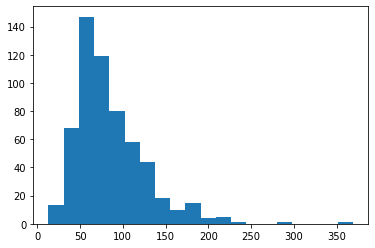

In [17]:
import matplotlib.pyplot as plt
list_size=list()
for elt in sentence_text:
    list_size.append(len(elt))
plt.hist(list_size, range = (min(list_size), max(list_size)), bins = 20)

In [18]:
print(np.mean(list_size))
print(np.quantile(list_size, 0.90))
print(np.quantile(list_size, 0.95))
print(np.quantile(list_size, 0.97))
print(np.quantile(list_size, 0.99))

84.97431506849315
134.70000000000005
164.70000000000005
180.52999999999997
209.33999999999992


## vocabulaire et index inputs

Nous allons indexée chaque mot par rapport au "inverse frequency" de 1 (le mot le plus commun sera 1, etc) jusqu à max_vocab. Nous reservons deux places : 0 pour le padding index PAD et MAX_VOCAB-1 pour les mots en dehors du vocabulaire ou inconnus (UNK).

In [19]:
# vocab dicts pour les annonces 
# on soustrait 2 pour UNK, PAD
word2idx, idx2word = get_vocab(sentence_text, MAX_VOCAB-2)

total vocab: 3413


In [22]:
# NER tag vocab dicts
ner2idx, idx2ner = get_vocab(sentence_ners, len(set(nertags))+2)

total vocab: 45


In [23]:
# index
sentence_text_idx = index_sents(sentence_text, word2idx)
sentence_ners_idx = index_sents(sentence_ners, ner2idx)

In [24]:
print(sentence_text_idx[0])

[  49    9  219  674    2   28  246    2  675   93   38  119  599    1
  235 1146    1  912  140  377    1    9   85   30   64    1   21    5
   45    6  282  540    1  160    1  204    1  223    1    7   24    2
   47   26    1   11  153   27    1   32    8   23    1   19    1   31
   35    1   12    1   10    2   34    1  199    4   13    3    7   37
    4    5   46   11   66   15   33    4   59   61   87]


## train-test splitting


In [25]:
indices = [i for i in range(len(sentence_text))]

train_idx, test_idx, y_train_ner, y_test_ner = train_test_split(indices, sentence_ners_idx, test_size=TEST_SIZE)

def get_sublist(lst, indices):
    result = []
    for idx in indices:
        result.append(lst[idx])
    return result

X_train_sents = get_sublist(sentence_text_idx, train_idx)
X_test_sents = get_sublist(sentence_text_idx, test_idx)

In [26]:
# network hyperparameters
MAX_LENGTH = 170 # par rapport a l histogramme, taille du vecteur
MAX_VOCAB = 5000    
WORDEMBED_SIZE = 300 
HIDDEN_SIZE = 400    # LSTM Nodes/Features/Dimension
BATCH_SIZE = 4
DROPOUTRATE = 0.20
MAX_EPOCHS = 5       

On doit utiliser le padding pour les vecteurs en input et output soit de taille fixe (MAX_LENGTH)

In [28]:
X_train_sents = sequence.pad_sequences(X_train_sents, maxlen=MAX_LENGTH, truncating='post', padding='post')
X_test_sents = sequence.pad_sequences(X_test_sents, maxlen=MAX_LENGTH, truncating='post', padding='post')
y_train_ner = sequence.pad_sequences(y_train_ner, maxlen=MAX_LENGTH, truncating='post', padding='post')
y_test_ner = sequence.pad_sequences(y_test_ner, maxlen=MAX_LENGTH, truncating='post', padding='post')

In [29]:
X_train_sents[2]

array([ 203,   53, 2219,    7,   24,    2,   54,   26,    2, 2220,   22,
         49,   16,  149,    6,    7,   96,  339,   32,    8,    5,   23,
          6,    7,   62,    1,    7,   19,    1,    5,   12,   40,    4,
       1058,   41,    1,    5,   36,    6,    7,   62,    1,    5,   10,
          2,   34,    1,   13,    1,    7,   37,   16,   66,    3,  865,
        477, 1074,   55,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [30]:
# Nombre de labels
NER_VOCAB = len(list(idx2ner.keys()))
print("Le nombre de labels est de :",NER_VOCAB)

Le nombre de labels est de : 47


In [31]:
# On reshape la data pour la couche CRF
y_train_ner = y_train_ner[:, :, np.newaxis]
y_test_ner = y_test_ner[:, :, np.newaxis]

# Reseau de neurones BiLSTM-CRF

In [32]:
# text layers 
txt_input = Input(shape=(MAX_LENGTH,), name='txt_input')
txt_embed = Embedding(MAX_VOCAB, WORDEMBED_SIZE, input_length=MAX_LENGTH,
                      name='txt_embedding', trainable=True, mask_zero=True)(txt_input)

txt_drpot = Dropout(DROPOUTRATE, name='txt_dropout')(txt_embed)

mrg_lstml = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True),
                          name='mrg_bidirectional_1')(txt_drpot)

# extra LSTM layer
mrg_drpot = Dropout(DROPOUTRATE, name='mrg_dropout')(mrg_lstml)
mrg_lstml = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True),
                          name='mrg_bidirectional_2')(mrg_lstml)

# final linear chain CRF layer
crf = CRF(NER_VOCAB, sparse_target=True)
mrg_chain = crf(mrg_lstml)

model = Model(inputs=[txt_input], outputs=mrg_chain)

model.compile(optimizer='adam',
              loss=crf.loss_function,
              metrics=[crf.accuracy])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



C:\Users\sujiv\Anaconda3\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
C:\Users\sujiv\Anaconda3\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
txt_input (InputLayer)       (None, 170)               0         
_________________________________________________________________
txt_embedding (Embedding)    (None, 170, 300)          1500000   
_________________________________________________________________
txt_dropout (Dropout)        (None, 170, 300)          0         
_________________________________________________________________
mrg_bidirectional_1 (Bidirec (None, 170, 800)          2243200   
_________________________________________________________________
mrg_bidirectional_2 (Bidirec (None, 170, 800)          3843200   
_________________________________________________________________
crf_1 (CRF)                  (None, 170, 47)           39950     
Total params: 7,626,350
Trainable params: 7,626,350
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model.fit([X_train_sents], y_train_ner,
                    batch_size=BATCH_SIZE,
                    epochs=MAX_EPOCHS,
                    verbose=2)


Epoch 1/5
 - 722s - loss: 6.1582 - crf_viterbi_accuracy: 0.8530
Epoch 2/5
 - 528s - loss: 5.7220 - crf_viterbi_accuracy: 0.8839
Epoch 3/5
 - 419s - loss: 5.4902 - crf_viterbi_accuracy: 0.9323
Epoch 4/5
 - 414s - loss: 5.3789 - crf_viterbi_accuracy: 0.9584
Epoch 5/5
 - 414s - loss: 5.3353 - crf_viterbi_accuracy: 0.9676


In [35]:
hist_dict = history.history

KeyError: 'val_loss'

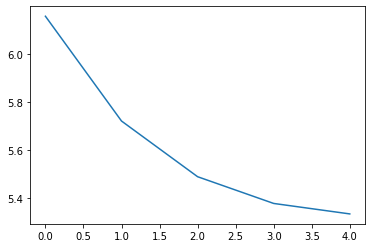

In [72]:


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [48]:
preds = model.predict([X_test_sents])

In [49]:
preds = np.argmax(preds, axis=-1)
trues = np.squeeze(y_test_ner, axis=-1)

In [50]:
s_preds = [[idx2ner[t] for t in s] for s in preds]
s_trues = [[idx2ner[t] for t in s] for s in trues]

In [61]:
sorted_labels = sorted(
    list(ner2idx.keys())[1:-2], 
    key=lambda name: (name[1:], name[0])
)

In [58]:
from sklearn_crfsuite import metrics
print(metrics.flat_classification_report(
    s_trues, s_preds, labels=sorted_labels, digits=3
))

C:\Users\sujiv\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


                          precision    recall  f1-score   support

               B-ADRESSE      0.847     0.714     0.775        70
               I-ADRESSE      0.904     0.591     0.715       176
    B-ANNEE_CONSTRUCTION      0.778     0.259     0.389        27
    I-ANNEE_CONSTRUCTION      0.000     0.000     0.000         6
        B-AVEC_ASCENSEUR      0.831     0.806     0.818        67
        I-AVEC_ASCENSEUR      0.790     0.961     0.867        51
B-CHARGES_LOCATAIRE_MOIS      0.812     0.839     0.825        31
I-CHARGES_LOCATAIRE_MOIS      0.000     0.000     0.000         0
           B-CODE_POSTAL      0.000     0.000     0.000         8
           B-COPROPRIETE      0.900     0.429     0.581        21
           I-COPROPRIETE      0.000     0.000     0.000         0
            B-DATE_DISPO      0.815     0.537     0.647        41
            I-DATE_DISPO      0.857     0.581     0.692        31
        B-DEPOT_GARANTIE      0.818     0.600     0.692        15
        I

Les résultats sont similaires au modele CRF (cf partie 1).

In [62]:
decoded = []
for sent_idx in range(len(X_test_sents)):
    
    this_txt = sequence.pad_sequences([X_test_sents[sent_idx]], maxlen=MAX_LENGTH, truncating='post', padding='post')
    this_pred = model.predict([this_txt])
    this_pred = [np.argmax(p) for p in this_pred[0]]
    np.shape(this_pred)

    word, tru, prd = [], [], []

    # for each word in the sentence...
    for idx, wordid in enumerate(X_test_sents[sent_idx][:len(this_pred)]):

        # decode word
        word.append(idx2word[wordid])
        # decode true NER tag
        tru.append(idx2ner[int(y_test_ner[sent_idx][idx])])
        # decode prediction
        prd.append(idx2ner[this_pred[idx]])

    answ = pd.DataFrame(
    {
        'word': word,
        'true': tru,
        'pred': prd,
        'skip' : [' ' for s in word]
    })
    answ = answ[['word', 'true', 'pred', 'skip']]
    answ = answ.T
    decoded.append(answ)

In [63]:
result = pd.concat(decoded)
result

,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
word,57,rue,gabriel,péri,-,à,8,minutes,à,pieds,...,PAD,PAD,PAD,PAD,PAD,PAD,PAD,PAD,PAD,PAD
true,B-ADRESSE,I-ADRESSE,I-ADRESSE,I-ADRESSE,O,O,O,O,O,O,...,PAD,PAD,PAD,PAD,PAD,PAD,PAD,PAD,PAD,PAD
pred,B-ADRESSE,I-ADRESSE,I-ADRESSE,I-ADRESSE,O,O,O,O,O,O,...,PAD,PAD,PAD,PAD,PAD,PAD,PAD,PAD,PAD,PAD
skip,,,,,,,,,,,...,,,,,,,,,,
word,quartier,schneider,",",rue,gambrinus,",",appartement,de,3,pièces,...,PAD,PAD,PAD,PAD,PAD,PAD,PAD,PAD,PAD,PAD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
skip,,,,,,,,,,,...,,,,,,,,,,
word,dans,petite,copropriété,très,bien,entretenue,à,5,mns,de,...,PAD,PAD,PAD,PAD,PAD,PAD,PAD,PAD,PAD,PAD
true,O,O,B-COPROPRIETE,O,O,O,O,O,O,O,...,PAD,PAD,PAD,PAD,PAD,PAD,PAD,PAD,PAD,PAD
pred,O,O,B-TRANSPORTS_PROXIMITE,O,O,O,O,O,O,O,...,PAD,PAD,PAD,PAD,PAD,PAD,PAD,PAD,PAD,PAD
